In [1]:
from allennlp.common import Params
from allennlp.data import DatasetReader
from allennlp.data.dataset import Batch
from allennlp.data.iterators import BasicIterator

from allennlp.models import Model

In [2]:
import sys
sys.path.append('/home/emelyanov-yi/PycharmProjects/kaggle_tf2_qa/')

In [3]:
from src import NaturalQuestionsModel, NaturalQuestionsDatasetReader

In [35]:
from typing import List, Dict, Tuple, Optional

In [4]:
prefix = '/home/emelyanov-yi/models/tf2_qa/init_fix_softmax'

In [5]:
params = Params.from_file(prefix + '/config.json')

In [7]:
model = Model.load(params, prefix)

In [24]:
reader = DatasetReader.from_params(params['dataset_reader'].duplicate())
reader._downsample_negative = 1.1
reader._downsample_all = 1.1

In [25]:
instances_gen = reader.read(params['validation_data_path'])

In [26]:
for inst in instances_gen:
    break

In [27]:
batch = Batch([inst])
batch.index_instances(model.vocab)
res = model.forward_on_instance(inst)

In [31]:
res.keys()

dict_keys(['start_logits', 'end_logits', 'label_logits', 'mask', 'meta', 'loss', 'label_loss', 'qa_loss'])

In [32]:
res.update(**res['meta'])

In [34]:
res.keys()

dict_keys(['start_logits', 'end_logits', 'label_logits', 'mask', 'meta', 'loss', 'label_loss', 'qa_loss', 'example_id', 'candidate_start_token', 'text', 'query', 'offset'])

In [28]:
print(inst)

Instance with fields:
 	 context: TextField of length 62 with text: 
 		[[CLS], the, name, of, the, separatist, political, party, in, quebec, [SEP], <Table>, <Tr>, <Td>,
		</Td>, <Td>, This, article, needs, additional, citations, for, verification, ., Please, help,
		improve, this, article, by, adding, citations, to, reliable, sources, ., Unsourced, material, may,
		be, challenged, and, removed, ., (, April, 2010, ), (, Learn, how, and, when, to, remove, this,
		template, message, ), </Td>, </Tr>, </Table>]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_start: IndexField with index: 10. 
 	 answer_end: IndexField with index: 10. 
 	 answer_label: LabelField with label: not_relevant in namespace: 'answer_labels'.' 



# From predictions for all paragraphs to one document-level prediction

In [36]:
from tqdm import tqdm

In [37]:
results: List[Dict] = []
for inst in tqdm(instances_gen):
    batch = Batch([inst])
    batch.index_instances(model.vocab)
    res = model.forward_on_instance(inst)
    
    res.update(**res['meta'])
    results.append(res)

135it [00:16, 13.40it/s]Too many wordpieces, truncating sequence. If you would like a sliding window, set `truncate_long_sequences` to False.The offending input was: ['[CLS]', 'the', 'name', 'of', 'the', 'separatist', 'political', 'party', 'in', 'quebec', '[SEP]', '<Ul>', '<Li>', 'Richard', 'Rohmer', "'s", 'novel', 'Separation', '(', '1976', ')', 'was', 'turned', 'into', 'a', 'TV', '-', 'movie', 'for', 'CTV', 'Television', 'in', '1977', '.', 'In', 'the', 'movie', ',', 'the', 'Parti', 'Québécois', 'has', 'formed', 'the', 'government', 'of', 'Quebec', 'but', 'Premier', 'Gaston', 'Belisle', 'has', 'repeatedly', 'put', 'off', 'its', 'promise', 'to', 'hold', 'a', 'referendum', '.', 'International', 'politics', 'forces', 'Belisle', "'s", 'hand', '.', '</Li>', '<Li>', 'In', 'the', 'mid-1980s', ',', 'a', 'second', 'movie', ',', 'Quebec', '-', 'Canada', '1995', ',', 'depicts', 'a', 'meeting', 'between', 'the', 'president', 'of', 'Quebec', 'and', 'the', 'prime', 'minister', 'of', 'Canada', 'to',

KeyboardInterrupt: 

In [54]:
from collections import defaultdict, OrderedDict

In [39]:
docwise_results = defaultdict(list)
for res in results:
    docwise_results[res['example_id']].append(res)

In [40]:
vocab = model.vocab  # for convenience ...

In [44]:
result['offset']

11

In [48]:
predictions: Dict[str, Tuple] = {}
    
for doc_id, all_results in tqdm(docwise_results.items()):
    long_answer_candidate = None
    for result in all_results:
        predicted_label = vocab.get_token_from_index(result['label_logits'].argmax(), namespace='answer_labels')
        if predicted_label in ['YES', 'NO']:
            # when we predict yes-no answer, we use current paragraph as long answer and do not check other paragraphs at all
            # TODO: get best match based on logits
            predictions[doc_id] = ((result['candidate_start_token'], result['candidate_start_token'] + len(result['document'])), predicted_label)
            break
        elif predicted_label == 'NONE':
            # paragraph is at least relevant, save it if there will be no other such prediction in the future
            # get predicted short answer (if exists)
            offset = result['offset']
            short_answer_start = res['start_logits'].argmax() - offset
            short_answer_end = res['end_logits'].argmax() - offset
            if short_answer_end >= short_answer_start \
                and short_answer_start >= 0:
                # found good short answer, break
                predictions[doc_id] = (long_answer_candidate, (short_answer_start, short_answer_end))
                break
            else:
                long_answer_candidate = (result['candidate_start_token'], result['candidate_start_token'] + len(result['text']))
    if long_answer_candidate is not None:
        predictions = (long_answer_candidate, '')
    else:
        predictions = ('', '')
    break

  0%|          | 0/161 [00:00<?, ?it/s]


In [49]:
predictions

((79, 118), '')

In [51]:
docwise_results.keys()

dict_keys([-1258974036110822789, -745542277813407309, -3489053283041023861, -4660970382607895773, -2286041252427312305, -3594846094801386035, 1100531970231406189, -4242445176318660699, -8610711774716247943, -7912859676267745845, 1347288971259022029, -1239741599579606102, -8566118151109196101, 7920718418002827464, 4055855179318578860, 232664088259764773, -5062984347125434513, -26744207835626469, -3769428450906292372, 2909502194213037723, -4322775683193696877, -1173805886994566979, -498275601085723935, -6256881697851641200, -2065095633122306018, -6092597371668069047, -8012102716327631486, -6336020651579045965, 1204288827337360876, -2232903166119770615, -5108190336222695693, -3183208779498643433, -8352843030477839032, 9188546442463987107, 470556784057779418, -6330465807440314122, -5368534122572265804, 1207247341423228973, -3149569811220675888, 5956049813952195977, -8617851792192749121, -88910826615454643, -8079942120175613865, -7157058681297025181, -3630115094940729861, -23318981026466616

In [53]:
type(doc_id)

int

In [ ]:
submission: Dict[str, str] = OrderedDict()
for doc_id in docwise_results:
    long_answer, short_answer = predictions[doc_id]
    submission(f'{doc_id}_long') = long_answer or '{}:{}'.format(*long_answer)
    

In [30]:
inst['meta'].metadata['candidate_start_token']

16

In [ ]:
dir(str)

In [20]:
import jsonlines

In [21]:
with jsonlines.open(params['validation_data_path']) as reader:
    for line in reader:
        break

In [22]:
line.keys()

dict_keys(['document_text', 'long_answer_candidates', 'question_text', 'annotations', 'document_url', 'example_id'])

In [29]:
line['long_answer_candidates']

[{'start_token': 16, 'top_level': True, 'end_token': 67},
 {'start_token': 17, 'top_level': False, 'end_token': 66},
 {'start_token': 79, 'top_level': True, 'end_token': 118},
 {'start_token': 118, 'top_level': True, 'end_token': 381},
 {'start_token': 381, 'top_level': True, 'end_token': 497},
 {'start_token': 497, 'top_level': True, 'end_token': 607},
 {'start_token': 607, 'top_level': True, 'end_token': 678},
 {'start_token': 907, 'top_level': True, 'end_token': 963},
 {'start_token': 971, 'top_level': True, 'end_token': 1084},
 {'start_token': 1084, 'top_level': True, 'end_token': 1174},
 {'start_token': 1174, 'top_level': True, 'end_token': 1316},
 {'start_token': 1339, 'top_level': True, 'end_token': 1637},
 {'start_token': 1637, 'top_level': True, 'end_token': 1823},
 {'start_token': 1830, 'top_level': True, 'end_token': 1903},
 {'start_token': 1903, 'top_level': True, 'end_token': 2030},
 {'start_token': 2030, 'top_level': True, 'end_token': 2181},
 {'start_token': 2181, 'top_l

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
res['start_logits']

array([2.74120527e-12, 3.58257781e-12, 2.27677772e-12, 4.98013714e-11,
       1.75781449e-12, 3.93584228e-11, 2.65977018e-10, 2.47831053e-12,
       1.48078882e-10, 1.00000000e+00, 5.00546566e-12, 2.54231983e-11,
       2.72890814e-13, 7.21567988e-13, 1.86188386e-13, 8.06734440e-14,
       1.38707229e-13, 2.50405301e-13, 1.61096356e-13, 2.14020072e-13,
       1.43250090e-13, 5.75047226e-13, 1.77148538e-13, 1.84621090e-13,
       2.11917967e-13, 2.64569508e-13, 9.17822784e-13, 1.50097315e-13,
       1.70493082e-13, 8.20020321e-14, 1.00831520e-13, 1.08939645e-13,
       2.11119189e-09, 1.27482186e-13, 1.80516761e-13, 1.32638651e-13,
       7.32685017e-13, 6.41841940e-13, 1.78506610e-13, 1.64872605e-13,
       1.49719890e-13, 1.15443056e-13, 3.35153482e-13, 7.36383719e-13,
       1.59665656e-13, 5.13281431e-12, 6.47599108e-14, 1.55645164e-13,
       2.10130497e-13, 1.35983144e-13, 2.09678087e-13, 2.71303759e-13,
       1.35278968e-13, 1.80635942e-13, 9.07738579e-14, 2.36311052e-13,
      

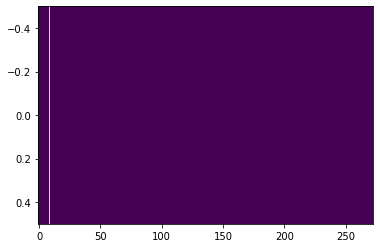

In [48]:
plt.imshow(res['start_logits'].reshape(1, -1), aspect='auto')

In [49]:
res['start_logits'].argmax()

9

In [51]:
res['end_logits'].argmax()

9

In [52]:
inst['meta'].metadata

{'example_id': -1258974036110822789,
 'text': ['<P>',
  'Several',
  'diverse',
  'political',
  'groups',
  'coalesced',
  'in',
  'the',
  'late',
  '1960s',
  'in',
  'the',
  'formation',
  'of',
  'the',
  'Parti',
  'Québécois',
  ',',
  'a',
  'provincial',
  'political',
  'party',
  '.',
  'Since',
  '1968',
  'the',
  'party',
  'has',
  'appealed',
  'for',
  'constitutional',
  'negotiations',
  'on',
  'the',
  'matter',
  'of',
  'provincial',
  'sovereignty',
  ',',
  'in',
  'addition',
  'to',
  'holding',
  'two',
  'provincial',
  'referendums',
  'on',
  'the',
  'matter',
  '.',
  'The',
  'first',
  ',',
  'which',
  'occurred',
  'in',
  '1980',
  ',',
  'asked',
  'whether',
  'Quebecers',
  'wished',
  'to',
  'open',
  'constitutional',
  'negotiations',
  'with',
  'the',
  'federal',
  'government',
  '(',
  'and',
  'other',
  'provinces',
  ')',
  'for',
  'the',
  'intended',
  'purpose',
  'of',
  'establishing',
  'a',
  '``',
  'sovereignty',
  '-',
  

In [53]:
res['label_logits']

array([ 3.3169417, -0.6555685, -3.7547233, -4.293389 ], dtype=float32)

In [55]:
model.vocab.get_token_to_index_vocabulary('answer_labels')

{'not_relevant': 0, 'NONE': 1, 'YES': 2, 'NO': 3}